In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from keras.models import *
from keras.preprocessing import image
import os, shutil
import warnings



import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns

import requests
from PIL import Image
from io import BytesIO

from tensorflow.keras.models import load_model


2025-05-25 17:48:02.456384: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748195282.651981      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748195282.705668      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


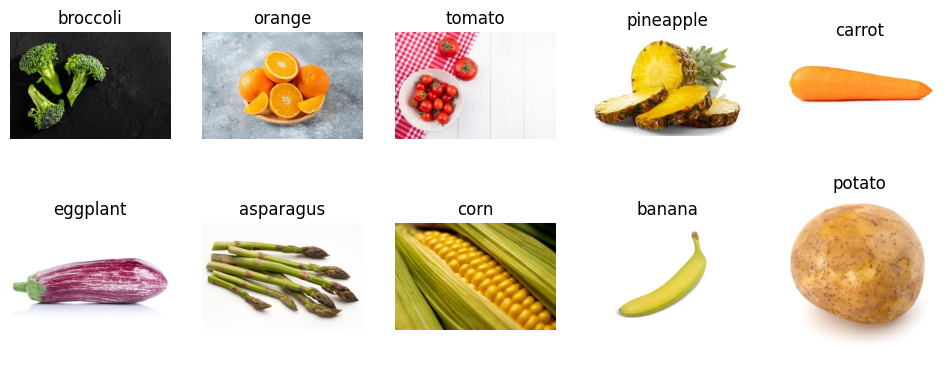

In [2]:
train_path = "/kaggle/input/vegetable-classification/train"
validation_path = "/kaggle/input/vegetable-classification/val"
test_path = "/kaggle/input/vegetable-classification/test"

image_categories = os.listdir(train_path)

def plot_images(image_categories):
    
    # Create a figure
    plt.figure(figsize=(12, 12))
    for i, cat in enumerate(image_categories):
        
        # Load images for the ith category
        image_path = train_path + '/' + cat
        images_in_folder = os.listdir(image_path)
        first_image_of_folder = images_in_folder[0]
        first_image_path = image_path + '/' + first_image_of_folder
        img = image.load_img(first_image_path)
        img_arr = image.img_to_array(img)/255.0
        
        
        # Create Subplot and plot the images
        plt.subplot(5, 5, i+1)
        plt.imshow(img_arr)
        plt.title(cat)
        plt.axis('off')
        
    plt.show()

# Call the function
plot_images(image_categories)

In [3]:
BATCHSIZE = 128
TARGETSIZE = (224, 224)

train_gen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    
)

train_image_generator = train_gen.flow_from_directory(
    train_path,
    target_size=TARGETSIZE,
    batch_size=BATCHSIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42)

# 2. Validation Set
val_gen = ImageDataGenerator(rescale = 1.0/255.0) # Normalise the data
val_image_generator = val_gen.flow_from_directory(
    validation_path,
    target_size =TARGETSIZE,
    batch_size=BATCHSIZE,
    class_mode='categorical',
    shuffle=False)

# 3. Test Set
test_gen = ImageDataGenerator(rescale = 1.0/255.0) # Normalise the data
test_image_generator = test_gen.flow_from_directory(
    test_path,
    target_size=TARGETSIZE,
    batch_size=BATCHSIZE,
    class_mode='categorical',
    shuffle=False )

Found 7000 images belonging to 10 classes.
Found 1500 images belonging to 10 classes.
Found 1500 images belonging to 10 classes.


In [4]:
print(train_image_generator.class_indices)

{'asparagus': 0, 'banana': 1, 'broccoli': 2, 'carrot': 3, 'corn': 4, 'eggplant': 5, 'orange': 6, 'pineapple': 7, 'potato': 8, 'tomato': 9}


In [5]:
NUMCLASSES = 10
def cnn_model(input_shape=(224, 224, 3), num_classes=NUMCLASSES):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D(2, 2)(x)

    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(2, 2)(x)

    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D(2, 2)(x)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model


In [6]:
model = cnn_model()

I0000 00:00:1748195303.656052      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [7]:
model = cnn_model(num_classes=len(train_image_generator.class_indices))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,170,250 (42.61 MB)

 Trainable params: 11,170,250 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(
    monitor='val_loss',      # theo dõi validation loss
    patience=10,              # dừng sau 10 epoch không cải thiện
    restore_best_weights=True  # khôi phục weights tốt nhất khi dừng
)
checkpoint = ModelCheckpoint(
    "best_model.keras",
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    verbose=1
)

In [9]:
history = model.fit(
    train_image_generator,
    epochs=100,
    validation_data=val_image_generator,
    callbacks=[checkpoint, early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1748195313.544998      82 service.cc:148] XLA service 0x78e78c005090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748195313.545728      82 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748195313.873972      82 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-25 17:48:40.834802: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,32,111,111]{3,2,1,0}, f32[128,64,109,109]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-05-25 17:48:40.983522: E external/local_xla/x

 2/55 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.0820 - loss: 3.0572 

I0000 00:00:1748195322.902992      82 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2442 - loss: 2.3035
Epoch 1: val_loss improved from inf to 1.06311, saving model to best_model.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.2462 - loss: 2.2951 - val_accuracy: 0.6427 - val_loss: 1.0631
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5915 - loss: 1.1756
Epoch 2: val_loss improved from 1.06311 to 0.81929, saving model to best_model.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.5920 - loss: 1.1745 - val_accuracy: 0.7093 - val_loss: 0.8193
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6679 - loss: 0.9663
Epoch 3: val_loss improved from 0.81929 to 0.62614, saving model to best_model.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.6683 - loss: 0.9652 - val_accuracy: 0.7820 - val_loss: 0.6261
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7209 - loss: 0.8261
Epoch 4: val_loss did not improve from 0.62614
55/55 ━━━━━━━━━━━━━━━━━━━━ 95s 2

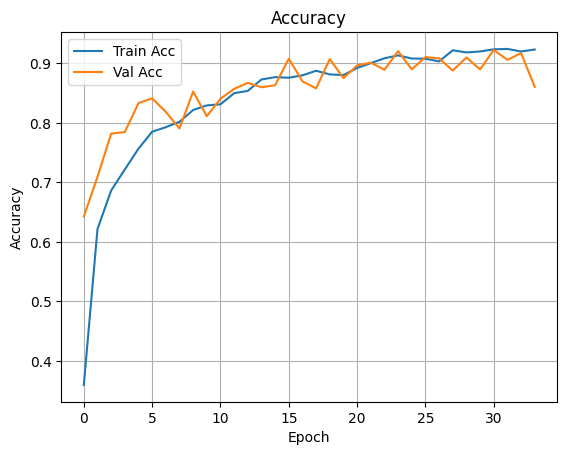

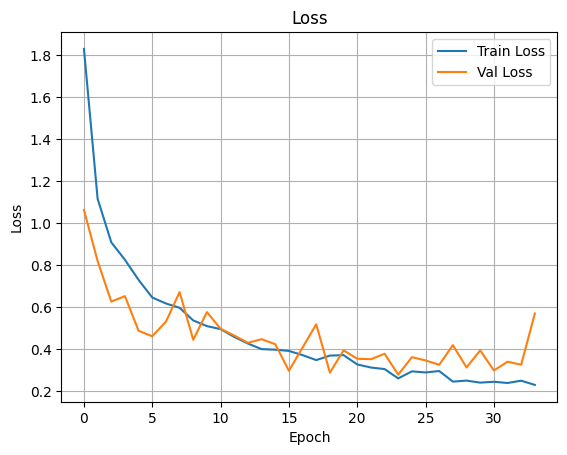

In [10]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
best_model = load_model('best_model.keras')

In [12]:
loss, accuracy = best_model.evaluate(test_image_generator)

12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8742 - loss: 0.3609


In [13]:
y_pred_probs = model.predict(test_image_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_image_generator.classes
class_labels = list(test_image_generator.class_indices.keys())
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 543ms/step
Classification Report:
              precision    recall  f1-score   support

   asparagus       0.94      0.81      0.87       150
      banana       0.95      0.77      0.85       150
    broccoli       0.89      0.99      0.94       150
      carrot       0.93      0.94      0.93       150
        corn       0.85      0.93      0.89       150
    eggplant       0.95      0.93      0.94       150
      orange       0.97      0.89      0.93       150
   pineapple       0.84      0.99      0.91       150
      potato       0.82      0.90      0.86       150
      tomato       0.98      0.92      0.95       150

    accuracy                           0.91      1500
   macro avg       0.91      0.91      0.91      1500
weighted avg       0.91      0.91      0.91      1500



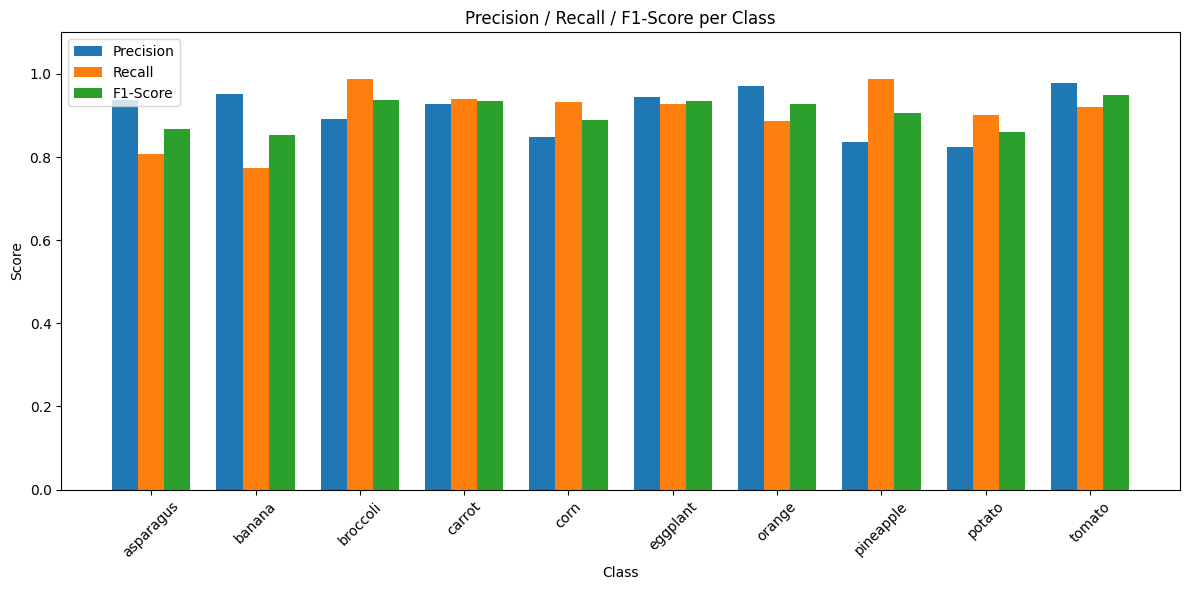

In [14]:
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)

x = range(len(class_labels))

plt.figure(figsize=(12, 6))
plt.bar(x, precision, width=0.25, label='Precision')
plt.bar([p + 0.25 for p in x], recall, width=0.25, label='Recall')
plt.bar([p + 0.50 for p in x], f1, width=0.25, label='F1-Score')

plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Precision / Recall / F1-Score per Class')
plt.xticks([p + 0.25 for p in x], class_labels, rotation=45)
plt.ylim([0, 1.1])
plt.legend()
plt.tight_layout()
plt.show()

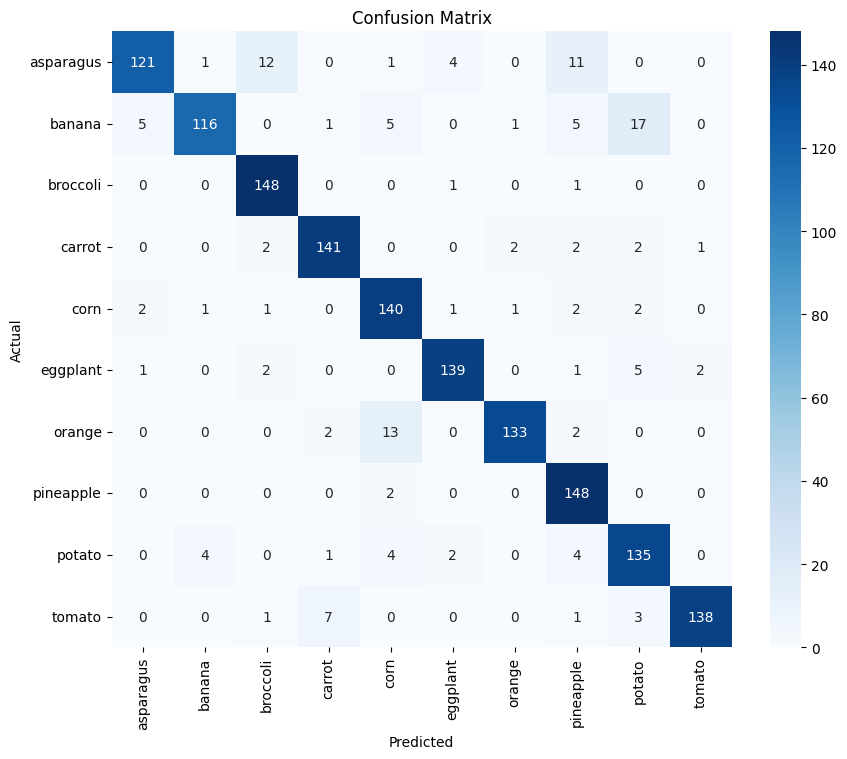

In [15]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [16]:
best_model.save('final_model.keras')

In [17]:
loadmodel=  load_model('final_model.keras')

In [18]:
def load_image_from_url(url, target_size=TARGETSIZE):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    img_resized = img.resize(target_size)
    img_array = np.array(img_resized) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Thêm batch dimension
    return img, img_array

def predict_images(model, image_urls, class_indices, target_size=TARGETSIZE):
    inv_class_indices = {v: k for k, v in class_indices.items()}

    for url in image_urls:
        try:
            img, img_data = load_image_from_url(url, target_size)
            pred_probs = model.predict(img_data)
            pred_class = np.argmax(pred_probs, axis=1)[0]
            predicted_label = inv_class_indices[pred_class]

            plt.figure()
            plt.imshow(img)
            plt.axis('off')
            plt.title(f'Predicted: {predicted_label}')
            plt.show()

        except Exception as e:
            print(f"Failed to process {url}: {e}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


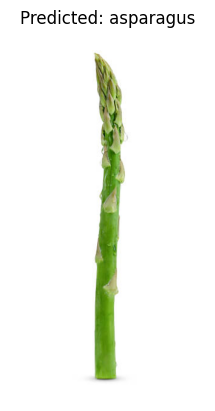

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


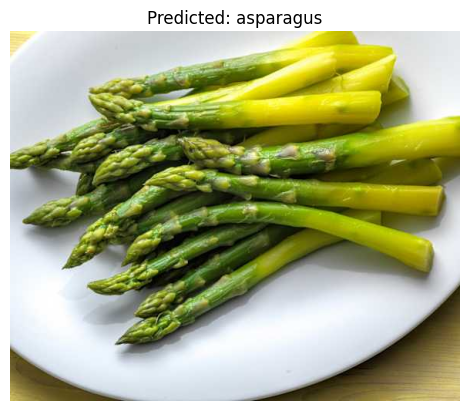

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


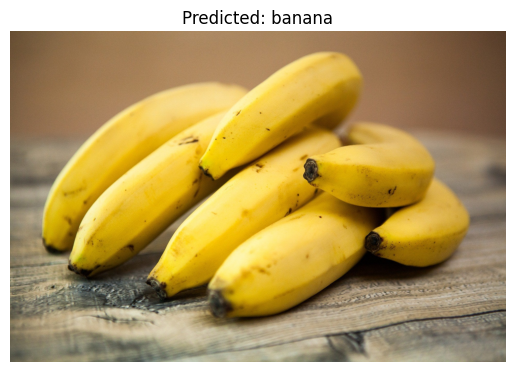

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


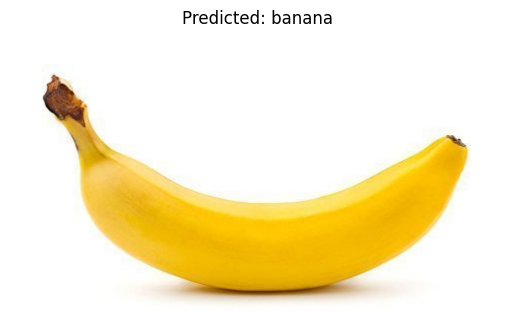

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


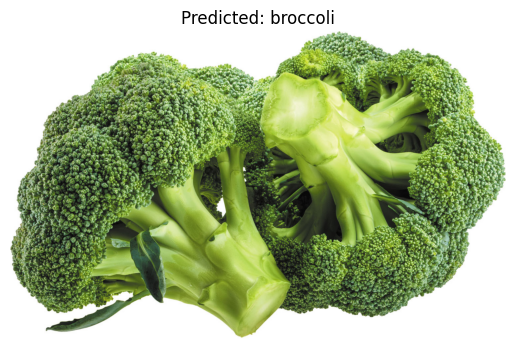

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


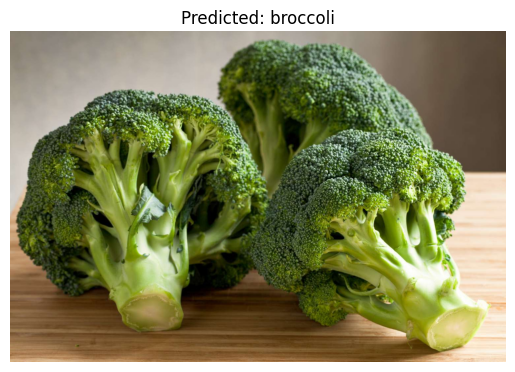

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


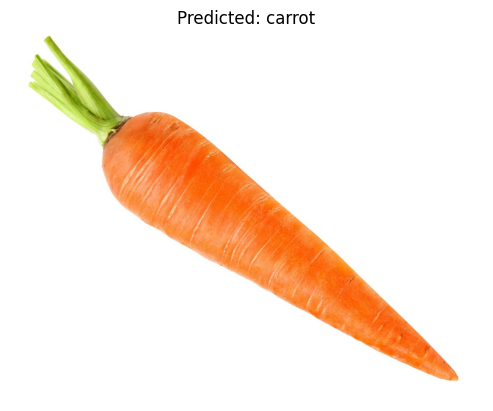

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


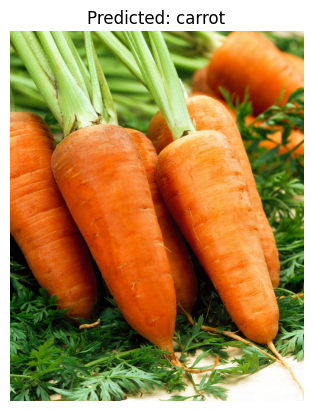

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


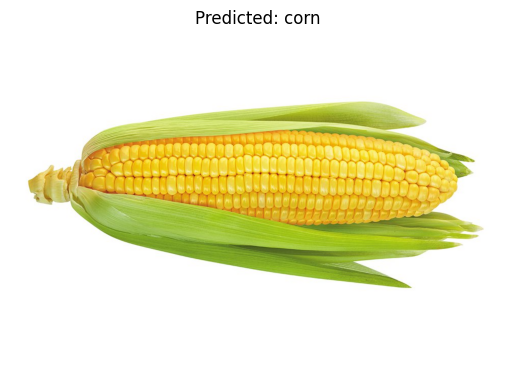

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


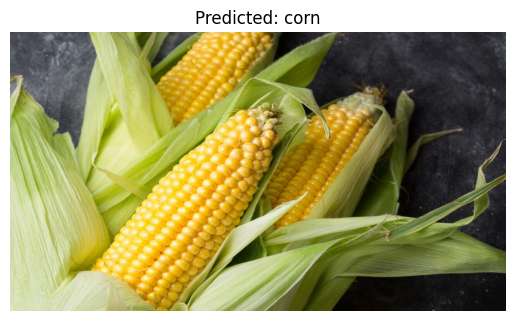

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


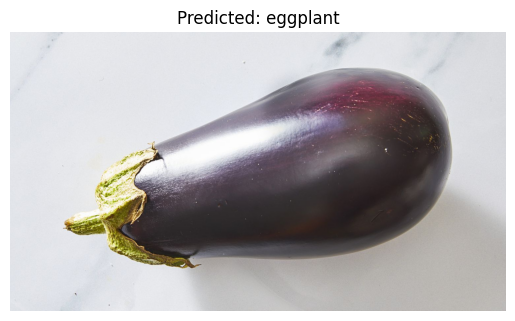

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


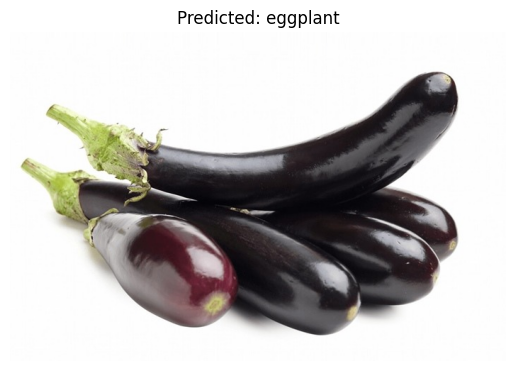

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


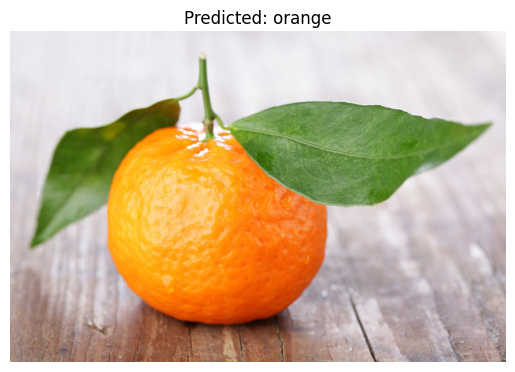

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


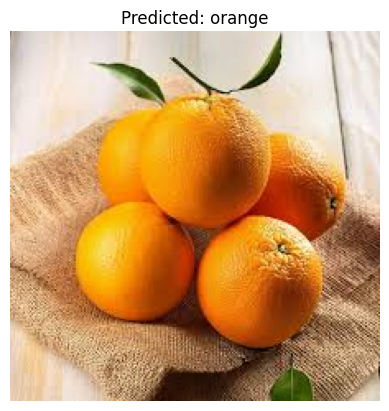

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


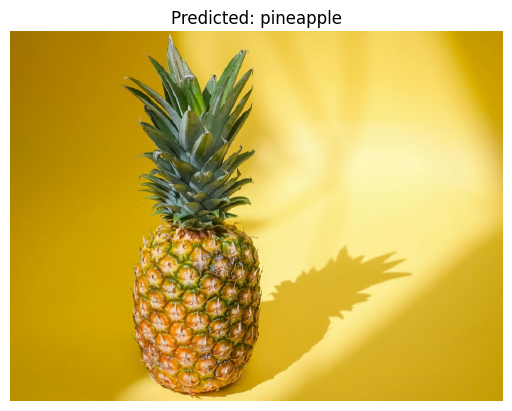

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


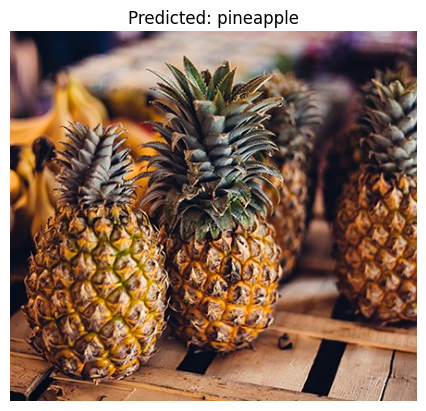

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


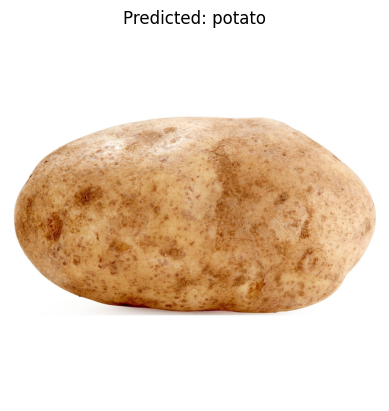

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


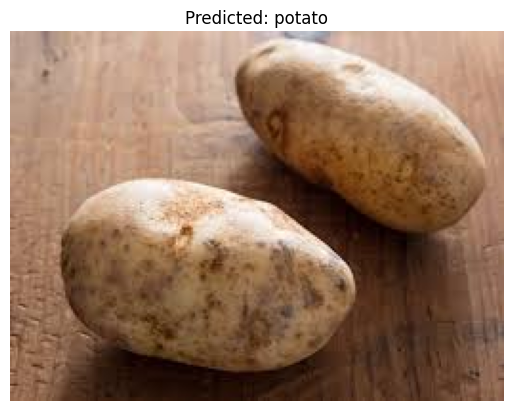

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


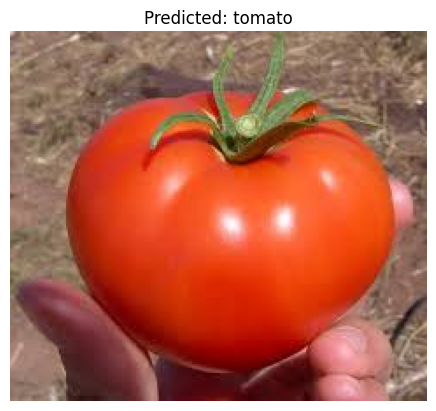

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


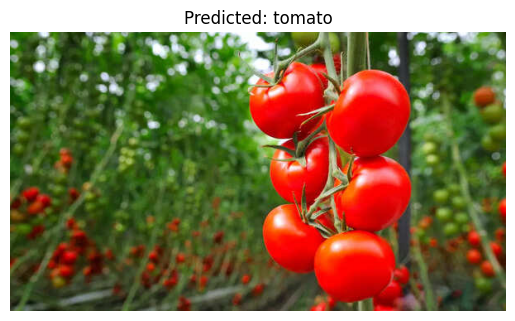

In [19]:
image_urls = [
    # Asparagus
    "https://media.istockphoto.com/id/1404417756/photo/single-stem-of-green-asparagus-isolated-with-clipping-path.jpg?s=612x612&w=0&k=20&c=po9AsZxHEvXIVk8ea5g37fUoJq0X0Bg2omvRHd1_138=",
    "https://assets.tmecosys.com/image/upload/t_web_rdp_recipe_584x480/img/recipe/ras/Assets/5b626c6f-f9ed-40f5-a73b-e758bffffd7c/Derivates/4928650e-dcee-4f15-86ab-6c263ed8232f.jpg",

    # Banana
    "https://nutritionsource.hsph.harvard.edu/wp-content/uploads/2018/08/bananas-1354785_1920.jpg",
    "https://m.media-amazon.com/images/I/31dke4F+cTL.jpg",

    # Broccoli
    "https://domf5oio6qrcr.cloudfront.net/medialibrary/5390/h1218g16207258089583.jpg",
    "https://www.simplyrecipes.com/thmb/v86cVS0MOs9K6NWE_cSYPMqnphw=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/Simply-Recipes-Best-Cooked-Broccoli-LEAD-1-bc173d890c834186a63654ea8948eec6.jpg",

    # Carrot
    "https://www.allthatgrows.in/cdn/shop/products/Carrot-Orange.jpg?v=1598079671",
    "https://egmontseeds.co.nz/cdn/shop/files/54161_Carrot_Chantenay_Red_Core.jpg?v=1719886349",


    # Corn
    "https://richmondmagazine.com/downloads/39615/download/Eat%26Drink_Ingredient_Corn1_GETTYIMAGES_rp0723.jpg?cb=226f9397bea90b2573b21c6ed73c69a6",
    "https://cdn.tgdd.vn/2021/10/CookDish/cac-cach-bao-quan-bap-ngo-tuoi-bap-da-luoc-bang-nhieu-phuong-avt-1200x676.jpeg",

    # Eggplant
    "https://www.southernliving.com/thmb/zIYF8tf18hVormy-OxqF-S7CCfI=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/Eggplant_003-0-acdc626b78c34962b62072863bf78fc7.jpg",
    "https://cdn.eva.vn/upload/2-2021/images/2021-06-06/mua-ca-tim-chon-qua-cong-hay-thang-thi-ngon-nguoi-trong-cay-mach-4-meo-cuc-chuan-612dd2ac17a94e33ac371befb17993be-1622974612-671-width700height464.jpg",

    # Orange
    "https://www.thespruceeats.com/thmb/oIV1zdRcUSV5z8oJSRBw5lIJcGA=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/Mandarin-Orange-581b2ccb3df78cc2e81b59a0.jpg",
    "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ3ijbcmdEXbhr9g4epZwEC9K_HS7HI_uXN_g&s",

    # Pineapple
    "https://images2.thanhnien.vn/528068263637045248/2024/6/19/4-trai-thom-pexels-1718771206834480215484.jpg",
    "https://images.immediate.co.uk/production/volatile/sites/30/2024/06/Pineapple-01-5562ee3.jpg?quality=90&resize=440,400",

    # Potato
    "https://i5.walmartimages.com/seo/Russet-Baking-Potatoes-Whole-Fresh-Each_c638c006-a982-48f7-aa33-6d3a8dc2983c.8fd015937ebfdd46c8fcb6177d0d1b1d.jpeg",
    "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTXHFmkS_R9DkBUh6RMii4PeytGPTdxMtrDwA&s",

    # Tomato
    "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRdebmxJt9HARKyPmQeeqSBJEO6oR473umE0Q&s",
    "https://static.toiimg.com/thumb/imgsize-23456,msid-120236037,width-600,resizemode-4/2-227.jpg"
]


predict_images(model, image_urls, train_image_generator.class_indices)